# KaldiTorch notebook

#### Packages

In [1]:
colab = False
if colab:
  from google.colab import drive
  ROOT = "/content/drive"
  drive.mount(ROOT)

In [2]:
!nvidia-smi

Wed Aug 12 09:35:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.126.02   Driver Version: 418.126.02   CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   41C    P0    63W / 300W |     11MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   45C    P0    68W / 300W |     11MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
if colab:
  %cd '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/pyscripts'

In [4]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torchsummary import summary
import matplotlib.pyplot as plt

import os
import math
import time
import sys
import shutil
import copy
import IPython.display as ipd

import numpy as np

if colab:
  !pip install -q livelossplot
  !pip install -q kaldi_io
  !pip install -q kaldiio
  os.environ['KALDI_ROOT'] = '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild'
else:
    os.environ['KALDI_ROOT'] = '/opt/kaldi/'
    
import kaldi_io
import kaldiio
#from livelossplot import PlotLosses
import librosa
from tqdm.notebook import tqdm
from pesq import pesq

In [5]:
# if colab:
#   sys.path.append('/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/pyscripts')

from models import DWaveNet
from datasets import SequenceDataset
from utils import ScheduledOptim, change_path_scp, EnergyConservingLoss, plot_modelPerformance, l1_mse_loss, splitAudio

In [6]:
train_dataset = SequenceDataset('../data/train/trainTOTAL.scp', '../data/utt2spkTOTAL.scp', min_length = 16000, colab = False)
test_dataset = SequenceDataset('../data/test/testTOTAL.scp', '../data/utt2spkTOTAL.scp', min_length = 16000, colab = False)

Totally 25334 samples with at most 247 samples for one class
Totally 5482 samples with at most 247 samples for one class


In [7]:
train_data = DataLoader(train_dataset, batch_size = 8, shuffle=True)
test_data = DataLoader(test_dataset, batch_size = 8, shuffle=True)

In [8]:
model = DWaveNet(in_channels = 1, target_field_length = None, num_layers = 30,
                 num_stacks = 3, residual_channels = 128,
                 gate_channels = 128, skip_out_channels = 128,
                 last_channels=(2048, 256))

In [9]:
if colab:
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  device
else:  
  os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1, 2, 3, 4'
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  device

In [14]:
optimizer = ScheduledOptim( # Transformer optimizer
        torch.optim.Adam(
            filter(lambda p: p.requires_grad,
                   model.parameters()),
            betas = (0.9, 0.98),
             eps = 1e-09,
              weight_decay = 1e-4,
               amsgrad = True),
                n_warmup_steps = 8000)

#optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.001, eps = 1e-08, weight_decay=0.0)
start_epoch = 1
best = {}
best['train'] = 100000
best['validation'] = 100000
best_epoch = -1
history = None

pretrain_model_pth = "../log/denoising/wavenetLAB/model_best.pth.tar"

if pretrain_model_pth is not None:
    if os.path.isfile(pretrain_model_pth):
        print('loading pre-trained model from %s' % pretrain_model_pth)
        model_dict = model.state_dict()
        checkpoint = torch.load(pretrain_model_pth, map_location = lambda storage, loc: storage) # load for cpu
        start_epoch = checkpoint['epoch'] + 1
        best_epoch = checkpoint['epoch']
        best = checkpoint['best_losses']
        history = checkpoint['history']
        #print(checkpoint['state_dict'])
        #model.load_state_dict(checkpoint['state_dict'])
        model.load_state_dict({k.replace('module.',''):v for k,v in checkpoint['state_dict'].items()})
        optimizer.load_state_dict(checkpoint['optimizer'])
    else:
        print("===> no checkpoint found at '{}'".format(pretrain_model_pth))
#         #exit()

loading pre-trained model from ../log/denoising/wavenetLAB/model_best.pth.tar


* SIG &rarr; predictor of signal distortion
* BAK &rarr; background noise intrusiveness predictor
* OVL &rarr; predictor of overall quality

In [15]:
def train_model(start_epoch, best, best_epoch, loaders, model, optimizer, use_cuda, history = None,
                verbose = True, log_dir = '../log/denoising/wavenet5/', save = True):
  idx = np.random.randint(len(test_data.dataset))
  clean, dirty, _ = test_dataset[idx]

  if use_cuda:
    model = nn.DataParallel(model)
    model = model.to(device)

  if history is None:
    logs = {}
    logs['train'] = []
    logs['validation'] = []
  else:
    logs = copy.deepcopy(history)

  for epoch in range(start_epoch, start_epoch + 50):  
    epoch_losses = {}
    #pesqs = []
    
    for phase in ['train', 'validation']:
      
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      if phase == 'train':
        print('Epoch %d' % epoch)
        start = time.time()
      
      running_loss = 0.0
      
      for batch_idx, (target, data, _) in enumerate(tqdm(loaders[phase])):

        if use_cuda:
          data, target = data.to(device), target.to(device)
        
        if phase == 'validation':
            with torch.no_grad():
                output = model(data)
        
        output = model(data)
        loss = EnergyConservingLoss(data, output, target)

        if phase == 'train':
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          lr = optimizer.update_learning_rate()
          #lr = 0.001
        running_loss += loss.detach() #* data.size(0))
        
#         if phase == 'validation':
#             pesqs.extend([pesq(fs = 16000, ref = audio[0].squeeze(0).cpu().detach().numpy(),
#                                deg = audio[1].squeeze(0).cpu().detach().numpy(), mode = 'wb') for audio in zip(data, output)])

        del data, target, output, loss

      epoch_loss =  running_loss / len(loaders[phase].dataset)
      epoch_losses[phase] = copy.deepcopy(epoch_loss.item())
      if phase == 'train':
        if verbose:
          print('Train Epoch:{}\tlr:{:.5f}\tLoss:{:.6f}\tTime:{:.2f} m'.format(epoch, lr, epoch_loss, (time.time()-start)/60))
      else:
        if verbose:
          print('Validation Loss:{:.6f}'.format(epoch_loss))
      logs[phase].extend([epoch_loss.item()])
    if save:
      if ((epoch_losses['train'] < best['train']) and (epoch_losses['validation'] < best['validation'])):
        best = epoch_losses
        torch.save({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'best_losses': best,
            'optimizer' : optimizer.state_dict(),
            'history': logs
        }, log_dir + str(epoch) + "_" + str(sum(epoch_losses.values())) + ".h5")
        print("===> save to checkpoint at {}\n".format(log_dir + 'model_best.pth.tar'))
        shutil.copyfile(log_dir + str(epoch) + "_" + str(sum(epoch_losses.values())) +
                ".h5", log_dir + 'model_best.pth.tar')
        best_epoch = epoch
      elif epoch - best_epoch > 2:
        print('===> increase delta optimizer')
        optimizer.increase_delta()
        best_epoch = epoch

    plot_modelPerformance(logs, clean, dirty, model)

In [16]:
loaders = {'train' : train_data, 'validation' : test_data}

Epoch 66



Train Epoch:66	lr:0.00013	Loss:282.334442	Time:7.68 m



Validation Loss:324.201813


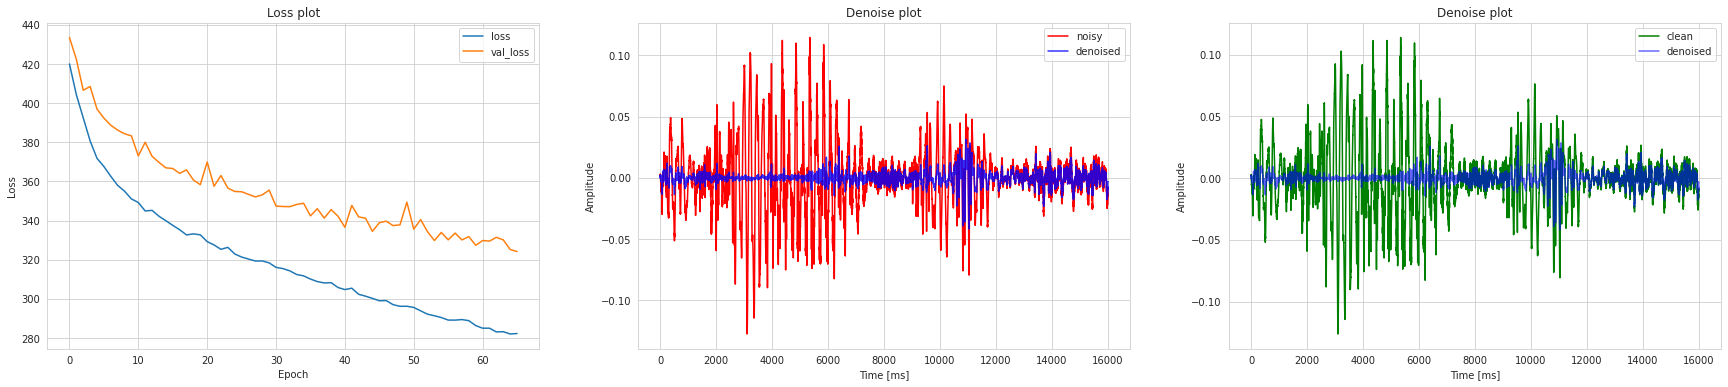

Epoch 67



Train Epoch:67	lr:0.00012	Loss:282.152802	Time:7.70 m



Validation Loss:328.754761


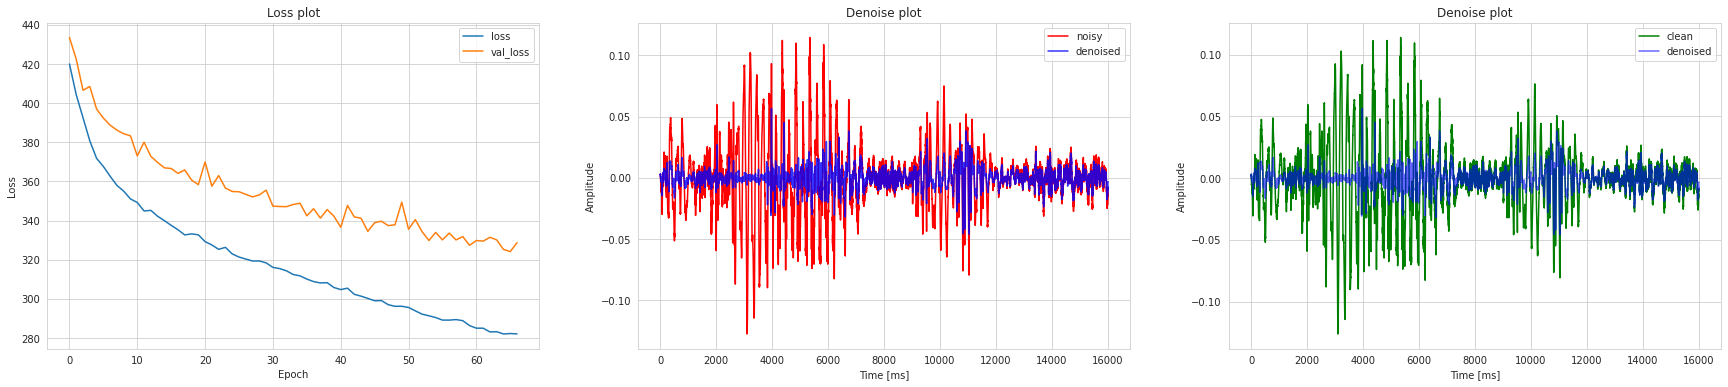

Epoch 68



Train Epoch:68	lr:0.00012	Loss:279.831299	Time:7.70 m



Validation Loss:328.840332
===> increase delta optimizer


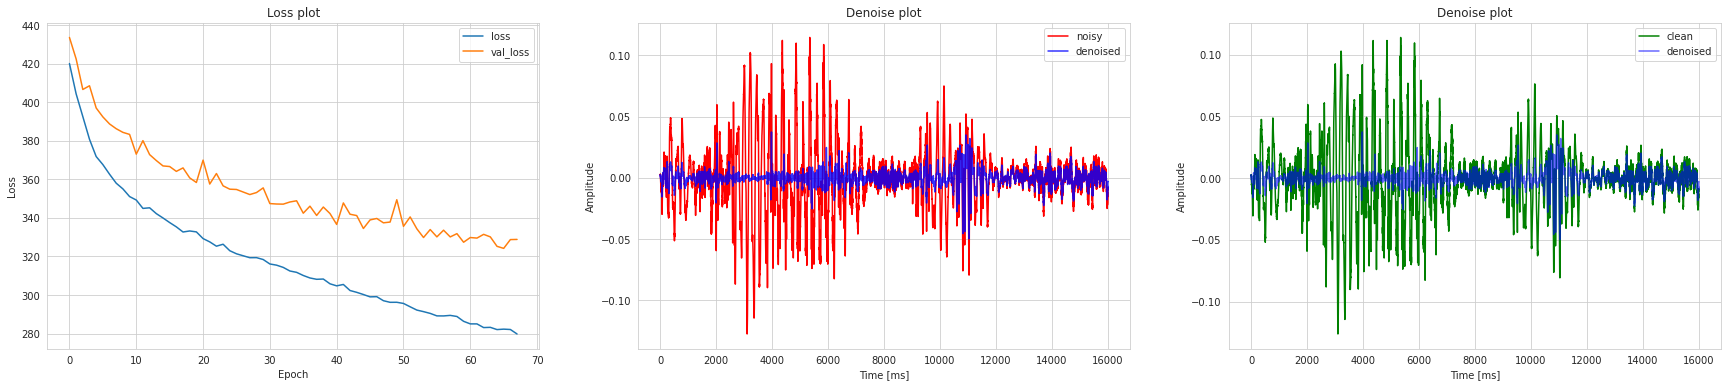

Epoch 69



Train Epoch:69	lr:0.00011	Loss:281.033020	Time:7.75 m



Validation Loss:324.592072
===> save to checkpoint at ../log/denoising/wavenetLAB/model_best.pth.tar



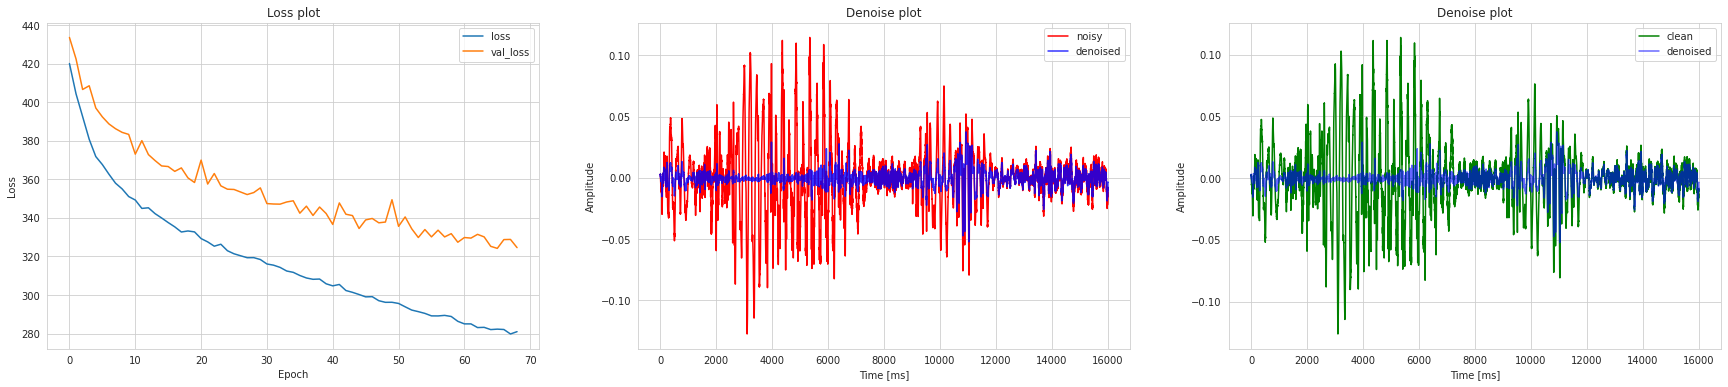

Epoch 70



Train Epoch:70	lr:0.00010	Loss:279.025635	Time:7.76 m



Validation Loss:329.176239


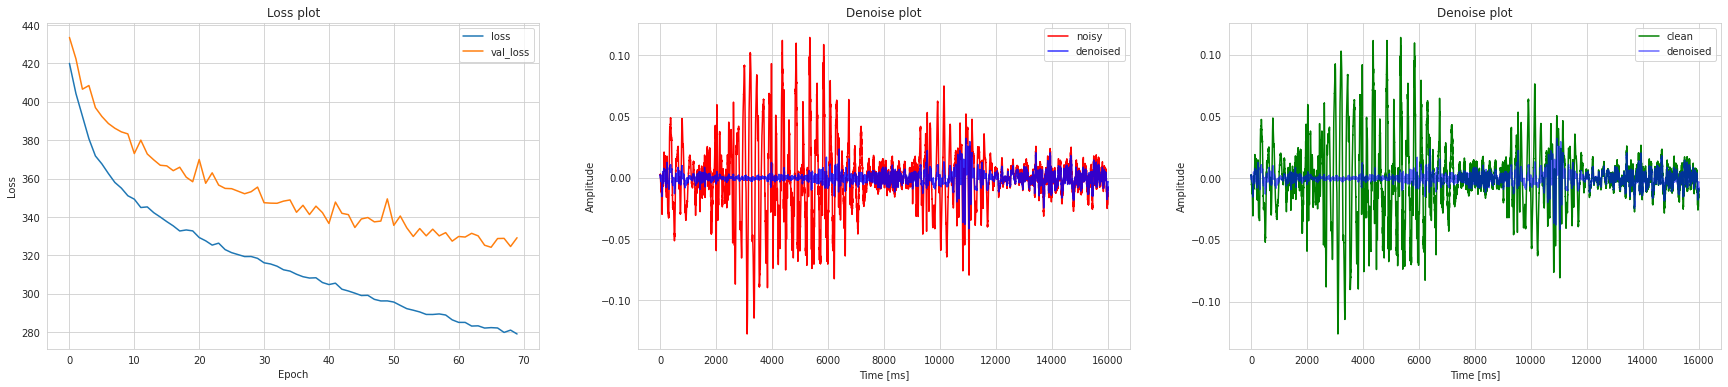

Epoch 71



Train Epoch:71	lr:0.00009	Loss:280.218445	Time:7.80 m



Validation Loss:322.287842
===> save to checkpoint at ../log/denoising/wavenetLAB/model_best.pth.tar



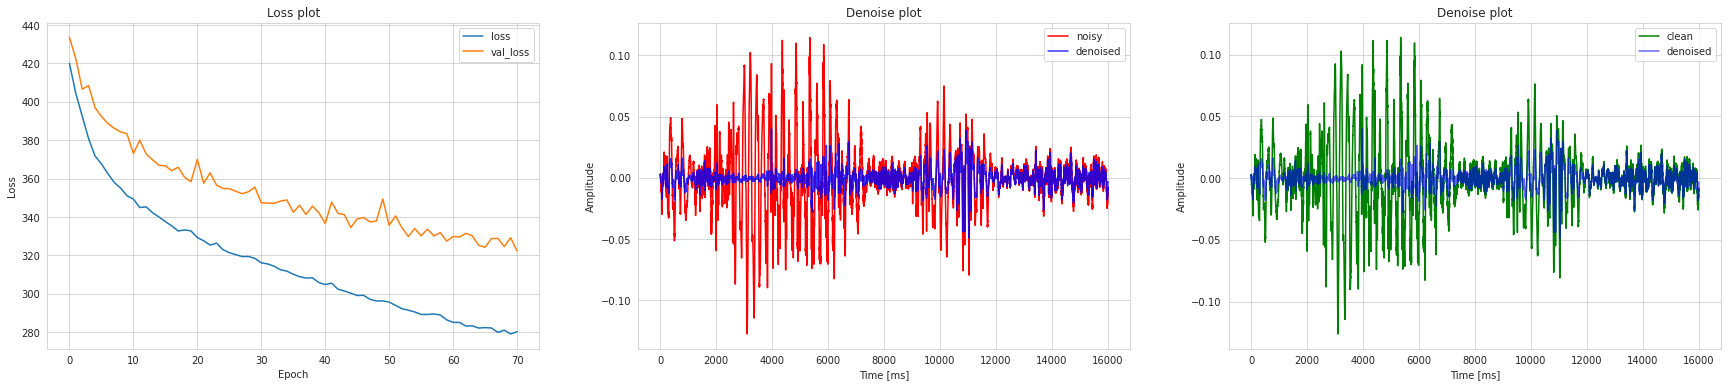

Epoch 72



Train Epoch:72	lr:0.00009	Loss:278.585693	Time:7.73 m



Validation Loss:322.713562


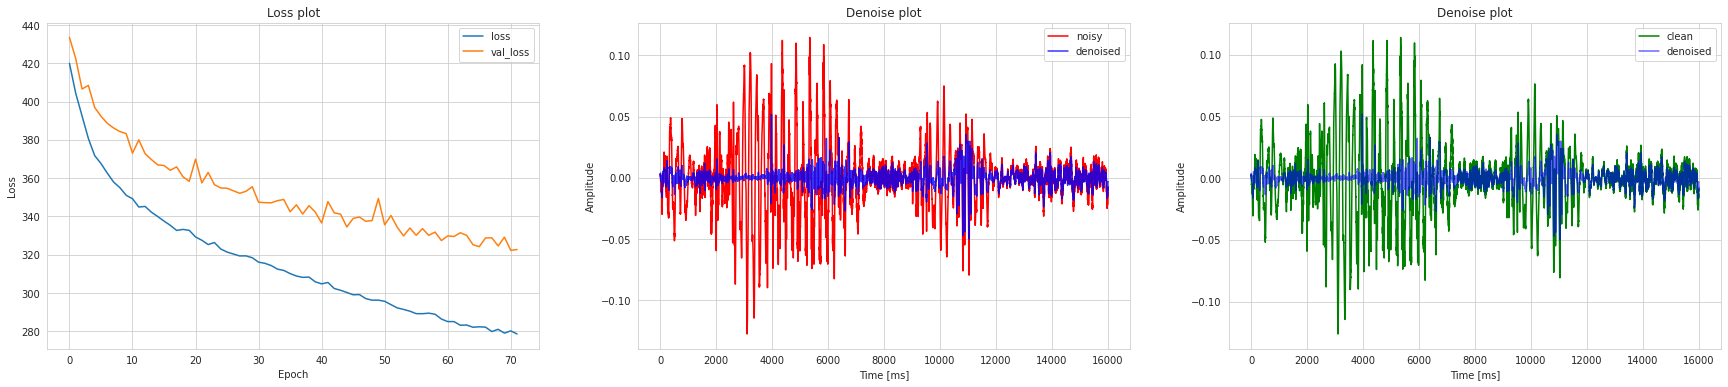

Epoch 73



Train Epoch:73	lr:0.00008	Loss:276.874237	Time:7.69 m



Validation Loss:324.878662


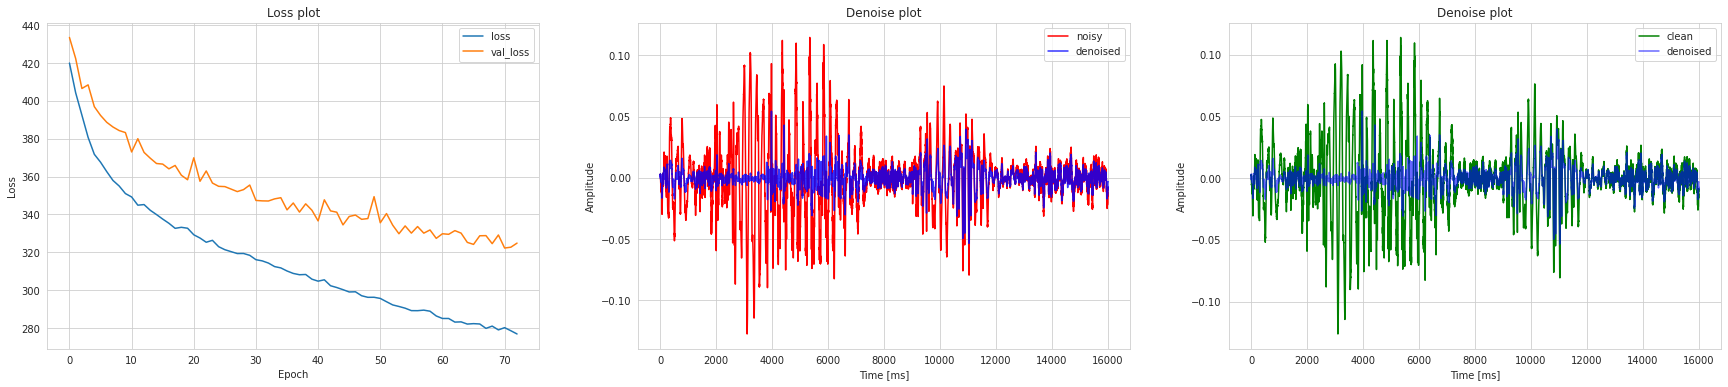

Epoch 74



Train Epoch:74	lr:0.00008	Loss:278.028778	Time:7.66 m



Validation Loss:326.032990
===> increase delta optimizer


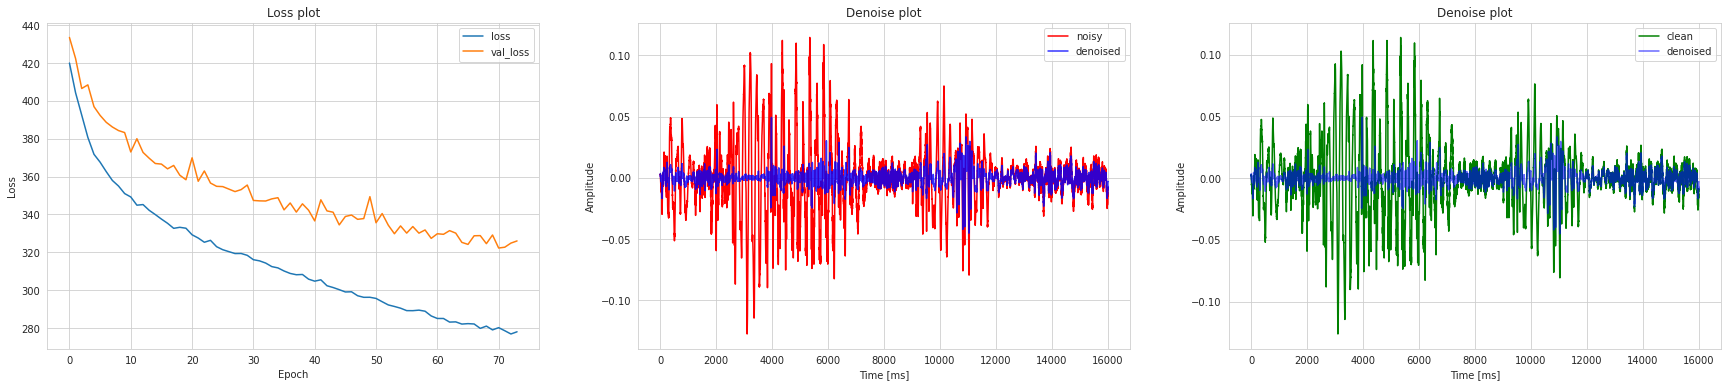

Epoch 75



Train Epoch:75	lr:0.00007	Loss:277.252716	Time:7.77 m



Validation Loss:328.183258


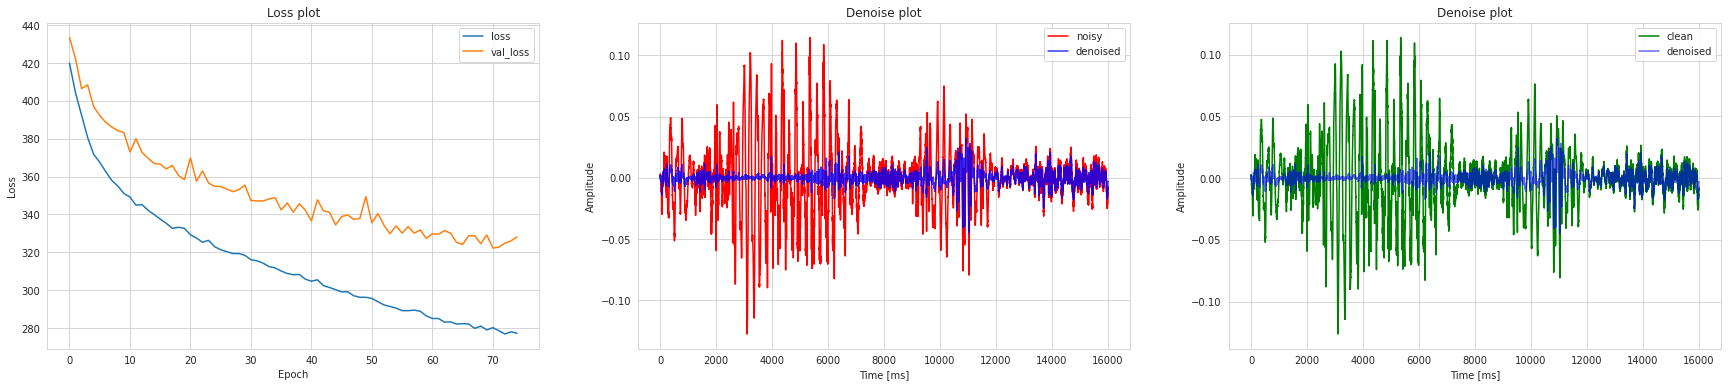

Epoch 76



Train Epoch:76	lr:0.00007	Loss:276.601593	Time:7.66 m



Validation Loss:330.110077


In [ ]:
train_model(start_epoch = start_epoch, best = best,
            best_epoch = best_epoch, loaders = loaders,
            model = model, optimizer = optimizer,# target_field_length = 16000,
            use_cuda = True, verbose = True, history = history, save = True, log_dir = '../log/denoising/wavenetLAB/')

<hr>

In [48]:
clean_audio, _ = librosa.load('/export/corpora/VoxCeleb1_test/wav/id10270/5r0dWxy17C8/00001.wav', sr = 16000)
noisy_audio, _ = librosa.load('/export/corpora/VoxCeleb1_test/wav/id10270/5r0dWxy17C8/00001_2.5.wav', sr = 16000)

In [49]:
from pesq import pesq

In [52]:
pesq(16000, clean_audio, noisy_audio, 'wb')#denoised_full.squeeze(0).squeeze(0).numpy(), 'wb')

1.7459070682525635

In [ ]:
target_field_length = 16000
duration = noisy_audio.shape[0]/target_field_length
splitted = np.array_split(noisy_audio, duration)
total = []
for frames in splitted:
  noisy_tensor = torch.from_numpy(frames).type(torch.FloatTensor).unsqueeze(0).unsqueeze(0).cuda()
  with torch.no_grad():
    model.eval()
    denoised_tensor = model(noisy_tensor).cpu()
  total.append(denoised_tensor)

torch.stack(total).size()

In [ ]:
model = model.cuda()
target_field_length = 16000
duration = noisy_audio.shape[0]/target_field_length
splitted = np.array_split(noisy_audio, duration)
total = []
for frames in splitted:
  noisy_tensor = torch.from_numpy(frames).type(torch.FloatTensor).unsqueeze(0).unsqueeze(0).cuda()
  with torch.no_grad():
    #model.eval()
    denoised_tensor = model(noisy_tensor).cpu()#.squeeze(0).squeeze(0).cpu()
  total.append(denoised_tensor)

denoised_audio = torch.cat(total, dim = 2)

In [ ]:
denoised_audio.size()

torch.Size([1, 1, 133761])

In [36]:
ipd.Audio(noisy_audio, rate = 16000)

In [38]:
ipd.Audio(denoised_full.squeeze(0).squeeze(0), rate = 16000)

In [50]:
with torch.no_grad():
  model.cuda()
  model.eval()
  denoised_full = model(torch.from_numpy(noisy_audio).type(torch.FloatTensor).unsqueeze(0).unsqueeze(0).cuda()).cpu()

In [19]:
import seaborn as sns

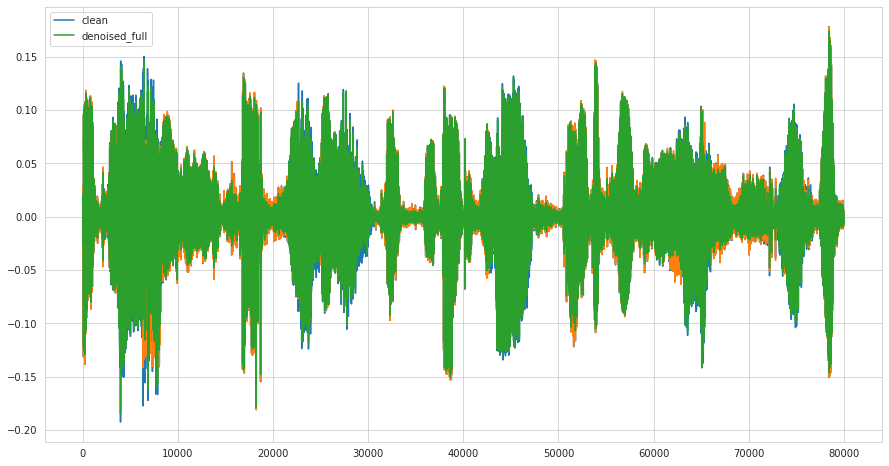

In [39]:
sns.set_style('whitegrid')
plt.figure(figsize = (15, 8))
plt.plot(noisy_audio, label = 'clean')
plt.plot(clean_audio)
plt.plot(denoised_full.squeeze(0).squeeze(0), label = 'denoised_full')
#plt.plot(denoised_audio.squeeze(0).squeeze(0), label = 'split denoising', alpha = .4)
plt.legend()

In [ ]:
noisy_audio, _ = librosa.load('/content/drive/My Drive/Datasets/VoxCeleb1_test/wav/id10270/5r0dWxy17C8/00001_2.5.wav', sr = 16000)

In [ ]:
import seaborn as sns

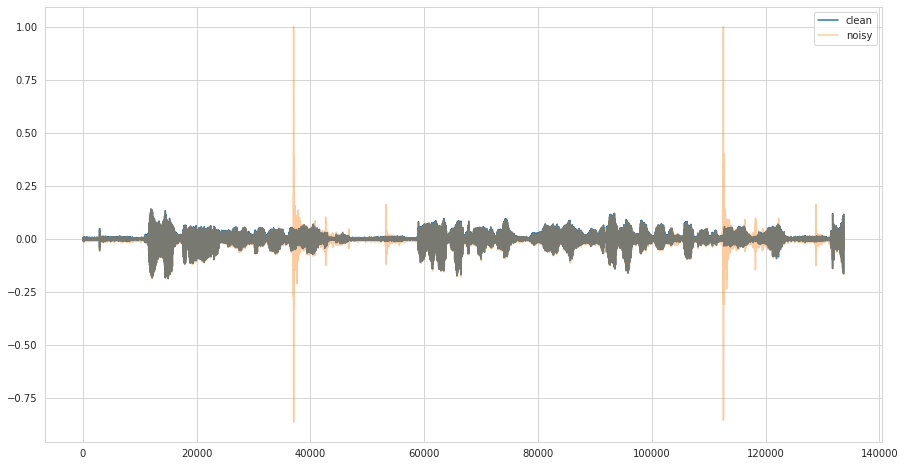

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize = (15, 8))
plt.plot(clean_audio, label = 'clean')
plt.plot(noisy_audio, label = 'noisy', alpha = .4)
plt.legend()

In [ ]:
test_dataset[0][1].squeeze(0)

torch.Size([1, 16000])

In [ ]:
noisy_tensor = torch.from_numpy(noisy_audio).type(torch.FloatTensor).unsqueeze(0).unsqueeze(0).cuda()

In [ ]:
model = model.cuda()

In [ ]:
with torch.no_grad():
  model.eval()
  denoised = model.forward(noisy_tensor)

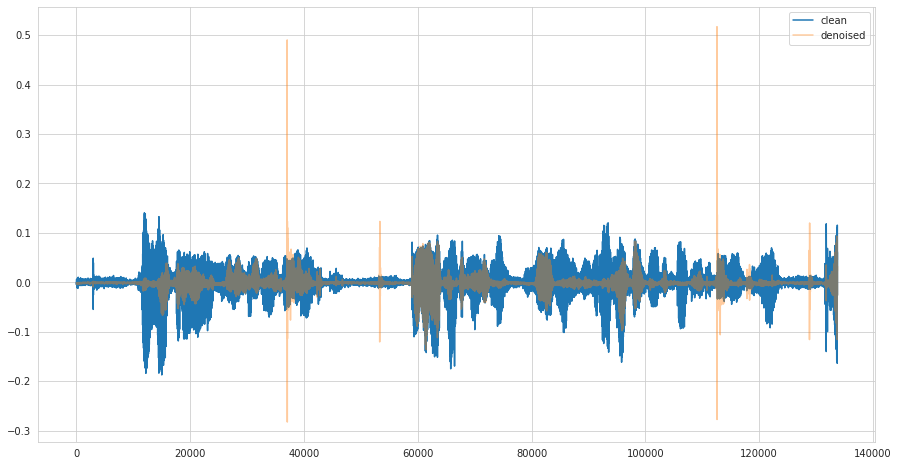

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize = (15, 8))
plt.plot(clean_audio, label = 'clean')
plt.plot(denoised.squeeze(0).squeeze(0).cpu(), label = 'denoised', alpha = .4)
plt.legend()

In [ ]:
ipd.Audio(denoised.squeeze(0).squeeze(0).cpu(), rate = 16000)